# Merixstudio tweet sentiment analysis

## Initial notebook settings

In [19]:
# General imports
import re
import numpy as np
from tqdm.notebook import tqdm
from typing import List

# Data preparation
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Vizualization
from matplotlib import pyplot as plt
from wordcloud import WordCloud

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from keras import utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# Download nltk resources
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Data Constants
DATA_LOCATION = "/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv"
GLOVE_LOCATION = "/kaggle/input/glove6b100dtxt/glove.6B.100d.txt"
STOP_WORDS = set(stopwords.words("english"))
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()

In [5]:
# Machine Learning Constants
RANDOM_STATE = 42  # Answer to Everything
NUMBER_OF_EPOCHS = 10
BATCH_SIZE = 1000
LEARNING_RATE = 0.001

## Preparing data for Machine Learning

The sentiment analysis dataset was downloaded from Kaggle and is available here:
- [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/kazanova/sentiment140)

In [6]:
# Load the twitter sentiment dataset
tweets = pd.read_csv(
    DATA_LOCATION,
    encoding="ISO-8859-1",
    header=None,
    names=(
        "target",
        "tweet_id",
        "date",
        "flag",
        "user",
        "text",
    ),
)
tweets.sample(10)

,target,tweet_id,date,flag,user,text
847743,4,1564647366,Mon Apr 20 04:24:14 PDT 2009,NO_QUERY,shaywalker8246,G/Morning! I woke up this mornin thinkin of al...
958001,4,1825608669,Sun May 17 06:16:59 PDT 2009,NO_QUERY,puppypupp21,"just woke up. going to ihop, and then two doub..."
656318,0,2240406133,Fri Jun 19 09:42:28 PDT 2009,NO_QUERY,j3r3myjf,"@andrewmcintyre Oh yeah, Youtube, Delicious et..."
1146454,4,1977928357,Sat May 30 22:01:40 PDT 2009,NO_QUERY,patriciaaro,@ddlovato cool. movie marathon! gonna have my ...
496369,0,2185529502,Mon Jun 15 17:31:05 PDT 2009,NO_QUERY,DannyJedi,really wants to go back home to Hawai'i.... Wa...
335793,0,2013864641,Tue Jun 02 23:47:26 PDT 2009,NO_QUERY,LaineMithra,another horrible day at work.
224636,0,1977457134,Sat May 30 21:00:55 PDT 2009,NO_QUERY,katiecraton,Bed early. Tomorrow i have to up way early
74897,0,1694973246,Mon May 04 04:47:26 PDT 2009,NO_QUERY,DarekMeridian,Spent the weekend taking car of Jason.. now I ...
1320824,4,2014624640,Wed Jun 03 02:08:50 PDT 2009,NO_QUERY,IamStefania,"@meganlouiise lol, yes, yes I am to adam sand..."
324993,0,2006869315,Tue Jun 02 11:48:18 PDT 2009,NO_QUERY,MajorLXXV,#Nintendo # E3 Starting to not care about Nint...


It is interesting to see that the authors of the dataset describe `3` values for the `target` of a tweet:
- `0` - negative, 
- `2` - neutral,
- `4` - positive.

If we check the actual counts of the dataset, we only have the following:

In [7]:
tweets.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

We will clean up the columns that won't be useful for us a bit and prepare the data for machine learning.

In [8]:
# Remove unused columns
tweets = tweets[["target", "text"]]

In [9]:
# Map target values to 0 and 1
tweets.target.replace({4: 1}, inplace=True)

In [10]:
# We will define this method as it will be useful later
def clean_tweet_text(text: str) -> str:
    # Clean mentions, punctuation, etc.
    tokens = re.sub(
        "(&gt;)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)",
        " ",
        text.lower(),
    ).split()

    # Remove english stop words
    tokens = [token for token in tokens if token not in STOP_WORDS]

    # Stem words (change to root form)
    tokens = [STEMMER.stem(token) for token in tokens]

    # Lemmatize words (get actual word for the language)
    tokens = [LEMMATIZER.lemmatize(token) for token in tokens]

    return " ".join(tokens)


clean_text = []
for text in tqdm(tweets.text, desc="Processing rows"):
    text = clean_tweet_text(text)
    clean_text.append(text)
tweets["clean_text"] = clean_text

tweets.sample(10)

Processing rows:   0%|          | 0/1600000 [00:00<?, ?it/s]

,target,text,clean_text
1076400,1,so basically I'm the be-dazzler to BK's fanny ...,basic dazzler bk fanni pack tht roll bitch
1568808,1,@izzyshoegal i dont really but i got the ap on...,dont realli got ap phone often yay lol
283747,0,@PoynterPerve don't be silly,silli
238613,0,I wish I had strawberries for sunday pancakes.,wish strawberri sunday pancak
994714,1,@pottymouthcon Glad you enjoyed..,glad enjoy
1540763,1,"@Ty_Nic @Roller_Novocain, @liza02, @ryanlochte...",nic novocain plzzz love haha ryan start innoc
104912,0,@mamitamala Did a bunch not show up?,bunch show
650578,0,safari 4.0. multiply 4.0. both ugly,safari multipli ugli
904238,1,heading off to schoool. going to have a good d...,head schoool go good day knoww
971238,1,aaaand here we are again,aaaand


Before we jump down into machine learning, let's see how the word cloud of this set looks like!

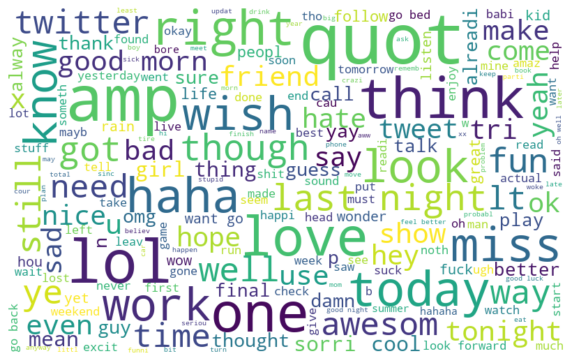

In [11]:
# Join all the words!
all_words = " ".join([text for text in tweets.clean_text])

# Create a word cloud
wordcloud = WordCloud(
    width=800,
    height=500,
    random_state=RANDOM_STATE,
    max_font_size=100,
    background_color="white",
).generate(all_words)

# And display it!
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Machine Learning

In [12]:
# Split data for training and testing
train, test = train_test_split(tweets[["clean_text", "target"]], test_size=0.1, random_state=RANDOM_STATE)

print(f"Shape of the train dataset: {train.shape}.")
print(f"Shape of the test dataset: {test.shape}.")

Shape of the train dataset: (1440000, 2).
Shape of the test dataset: (160000, 2).


In [13]:
# Add padding to shorted tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.clean_text)
vocabulary_size = len(tokenizer.word_index) + 1
max_length = 50  # The max number of tokens for a tweet, seems fitting since Twitter restricts number of chars

sequences_train = tokenizer.texts_to_sequences(train.clean_text)
sequences_test = tokenizer.texts_to_sequences(test.clean_text)

X_train = pad_sequences(sequences_train, maxlen=max_length, padding="post")
X_test = pad_sequences(sequences_test, maxlen=max_length, padding="post")
y_train = train.target.values
y_test = test.target.values

In [14]:
embed_dict = dict()
embed_dimensions = 100

with open(GLOVE_LOCATION) as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype="float32")
        embed_dict[word] = vector_dimensions

embed_matrix = np.zeros((vocabulary_size, embed_dimensions))
for word, index in tokenizer.word_index.items():
    embedding_vector = embed_dict.get(word)
    if embedding_vector is not None:
        embed_matrix[index] = embedding_vector

In [15]:
# Defining the embedding layer
embed_layer = tf.keras.layers.Embedding(
    input_dim=vocabulary_size,
    output_dim=embed_dimensions,
    input_length=max_length,
    weights=[embed_matrix],
    trainable=False,
)

# Defining the model
model = Sequential(
    [
        embed_layer,
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(128)),
        Dropout(0.4),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

In [16]:
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=["accuracy"],
)


def fit_model(model):
    return model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=NUMBER_OF_EPOCHS,
    validation_data=(X_test, y_test),
    verbose=2,
)

history = fit_model(model)

Epoch 1/10
1440/1440 - 102s - loss: 0.5346 - accuracy: 0.7268 - val_loss: 0.5078 - val_accuracy: 0.7448
Epoch 2/10
1440/1440 - 93s - loss: 0.5036 - accuracy: 0.7499 - val_loss: 0.4959 - val_accuracy: 0.7555
Epoch 3/10
1440/1440 - 92s - loss: 0.4928 - accuracy: 0.7573 - val_loss: 0.4909 - val_accuracy: 0.7588
Epoch 4/10
1440/1440 - 92s - loss: 0.4848 - accuracy: 0.7625 - val_loss: 0.4856 - val_accuracy: 0.7618
Epoch 5/10
1440/1440 - 92s - loss: 0.4783 - accuracy: 0.7668 - val_loss: 0.4823 - val_accuracy: 0.7634
Epoch 6/10
1440/1440 - 92s - loss: 0.4724 - accuracy: 0.7704 - val_loss: 0.4809 - val_accuracy: 0.7642
Epoch 7/10
1440/1440 - 92s - loss: 0.4670 - accuracy: 0.7738 - val_loss: 0.4791 - val_accuracy: 0.7663
Epoch 8/10
1440/1440 - 92s - loss: 0.4619 - accuracy: 0.7769 - val_loss: 0.4791 - val_accuracy: 0.7657
Epoch 9/10
1440/1440 - 92s - loss: 0.4568 - accuracy: 0.7799 - val_loss: 0.4793 - val_accuracy: 0.7672
Epoch 10/10
1440/1440 - 92s - loss: 0.4515 - accuracy: 0.7833 - val_loss

In [17]:
# Calculate y predictions based on the model
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76     79812
           1       0.75      0.81      0.77     80188

    accuracy                           0.77    160000
   macro avg       0.77      0.77      0.77    160000
weighted avg       0.77      0.77      0.77    160000



In [22]:
vectorizer = CountVectorizer()

last_mrx_tweet = "Wondering how to wow investors with your pitch deck? Check out what Marko Kyyrönen from @Sparkmind_VC has to say about that"
last_mrx_tweet = clean_tweet_text(last_mrx_tweet)
tweet_eval = [last_mrx_tweet]

tweet_eval_numeric = vectorizer.fit_transform(tweet_eval).toarray()
prediction = model.predict(tweet_eval_numeric)
print(prediction)

[[0.5894794]]
